<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-and-mangling-the-dataset" data-toc-modified-id="Importing-and-mangling-the-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing and mangling the dataset</a></span><ul class="toc-item"><li><span><a href="#Creating-the-$(U-\times-I)$-matrix" data-toc-modified-id="Creating-the-$(U-\times-I)$-matrix-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the $(U \times I)$ matrix</a></span></li></ul></li><li><span><a href="#Hierarchical-Poisson-Factorization" data-toc-modified-id="Hierarchical-Poisson-Factorization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hierarchical Poisson Factorization</a></span></li></ul></div>

# Importing and mangling the dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# load the datasets
plays = pd.read_csv("user_artists.dat", sep="\t")
artists = pd.read_csv("artists.dat", sep="\t", usecols=["id", "name"])

In [3]:
plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [4]:
artists.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [5]:
# merge the datasets
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap.rename({"weight": "playCount"}, axis=1, inplace=True)
ap.head()

,id,name,userID,artistID,playCount
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [6]:
# compute the number of unique users and total play count for each artist
artist_rank = ap.groupby("name").agg({"userID": "count", "playCount": "sum"})

# rename column names
artist_rank.rename({"userID": "totalUniqueUsers", "playCount": "totalArtistPlays"}, axis=1, inplace=True)

# create an average plays per user column
artist_rank["avgUserPlays"] = artist_rank['totalArtistPlays'] / artist_rank['totalUniqueUsers']

# sort values descendingly based on total plays
artist_rank.sort_values(by="totalArtistPlays", ascending=False, inplace=True)

artist_rank.head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148


In [7]:
# Now merge with the ap dataset, to have the aggregate info about each artist contained
# in artist_rank
ap = ap.join(artist_rank, on="name", how="inner").sort_values(['playCount'], ascending=False)

ap.head()

,id,name,userID,artistID,playCount,totalUniqueUsers,totalArtistPlays,avgUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376
35843,792,Thalía,2071,792,324663,26,350035,13462.884615
27302,511,U2,1094,511,320725,185,493024,2664.994595
8152,203,Blur,1905,203,257978,114,318221,2791.412281
26670,498,Paramore,1664,498,227829,399,963449,2414.659148


## Creating the $(U \times I)$ matrix

In [8]:
ratings_df = ap.pivot(index="userID", columns="artistID", values="playCount")
ratings_df.fillna(0, inplace=True)
# convert cells to introduce implicit feedback
ratings_df[ratings_df > 0] = 1

# transform ratings_df in a numpy array for faster computation
ratings = ratings_df.values

ratings_df.head(10)

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can quantify how sparse our matrix is, i.e. what percentage of the cells in it are actually filled.

In [9]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.28%


In [10]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

train, val = train_test_split(ratings)

# Hierarchical Poisson Factorization

In [12]:
from HPF import HPF

In [13]:
model = HPF(K=5, a_1=6, b_1=3, a=5, c_1=6, d_1=3, c=5)
model.fit(epochs=50, train=train, val=val)

HPF Val MSE: 0.9213 - Progress: 100%|██████████| 50/50 [09:39<00:00, 12.15s/it]


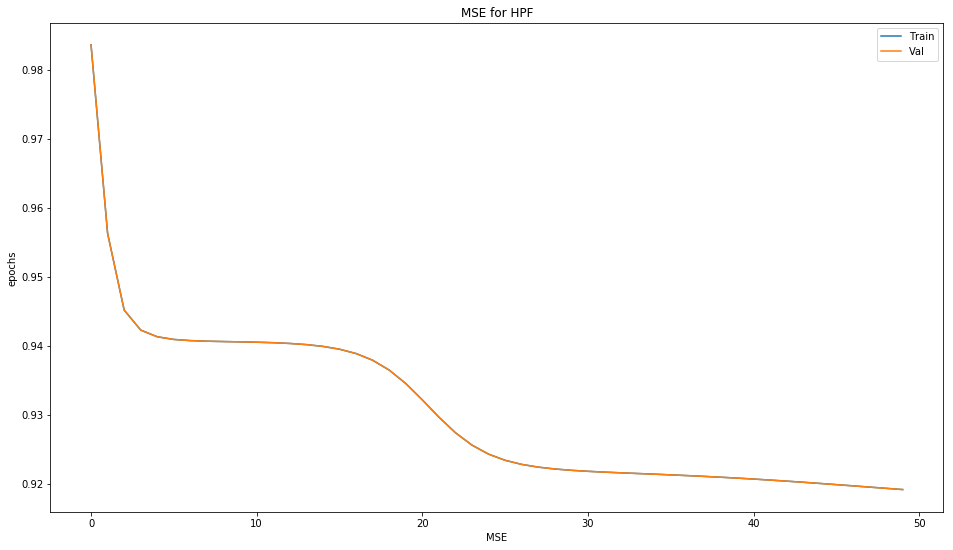

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(range(len(model.train_error)), model.train_error, label="Train")
ax.plot(range(len(model.val_error)), model.train_error, label="Val")
ax.set_title("MSE for HPF")
ax.set_xlabel("MSE")
ax.set_ylabel("epochs")
ax.legend();